# EUV Spectra Prediction Tutorial for Beginners 🌞

This notebook will guide you through running EUV (Extreme Ultraviolet) spectra prediction using the Surya model. 

## What you'll learn:
- How to load a pre-trained model for EUV spectra prediction
- How to run inference on solar data to predict 1343-dimensional spectra
- How to interpret spectral forecasting results
- Understanding vector predictions vs scalar outputs
- How to visualize and analyze EUV spectral data

## Prerequisites:
- Make sure you're in the correct directory: `downstream_examples/euv_spectra_prediction/`
- Ensure all required packages are installed (torch, yaml, matplotlib, numpy, etc.)

Let's get started! 🚀


In [1]:
import os
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
from huggingface_hub import snapshot_download

# Import functions from our inference script
from infer import (
    run_inference,
    create_spectrum_plots
)

# Import from surya
from surya.utils.data import build_scalers
from surya.utils.distributed import set_global_seed

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")


/rhome/rlal/Surya/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All imports successful!
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA H100 80GB HBM3


## Step 2: Download Pre-trained Model Weights

The model weights will be automatically downloaded from Hugging Face. This might take a few minutes on first run.


In [2]:
# Download model weights from Hugging Face
print("📥 Downloading model weights...")
snapshot_download(
    repo_id="nasa-ibm-ai4science/euv_spectra_surya",
    local_dir="./assets",
    allow_patterns='*.pth',
    token=None,
)
print("✅ Model weights downloaded successfully!")


📥 Downloading model weights...


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 523.63it/s]

✅ Model weights downloaded successfully!


## Step 3: Set Up Configuration

We need to load the configuration file that contains all the model and data parameters. Make sure you have a `config.yaml` file in your current directory.

In [3]:
# Configuration paths - modify these if your files are in different locations
config_path = "./config.yaml"
checkpoint_path = "./assets/euv_spectra_weights.pth"
output_dir = "./inference_results"

# Set global seed for reproducibility
set_global_seed(42)

# Load configuration
print("📋 Loading configuration...")
try:
    config = yaml.safe_load(open(config_path, "r"))
    config["data"]["scalers"] = yaml.safe_load(open(config["data"]["scalers_path"], "r"))
    print("✅ Configuration loaded successfully!")
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("Make sure config.yaml exists in your current directory")
    raise

# Set data type (float precision)
if config["dtype"] == "float16":
    config["dtype"] = torch.float16
elif config["dtype"] == "bfloat16":
    config["dtype"] = torch.bfloat16
elif config["dtype"] == "float32":
    config["dtype"] = torch.float32
else:
    raise NotImplementedError("Please choose from [float16,bfloat16,float32]")

print(f"Model type: {config['model']['model_type']}")
print(f"Data precision: {config['dtype']}")
print(f"Expected spectrum dimension: 1343")


📋 Loading configuration...
✅ Configuration loaded successfully!
Model type: spectformer
Data precision: torch.float32
Expected spectrum dimension: 1343


## Step 4: Set Up Device (GPU/CPU)

Let's determine whether to use GPU or CPU for inference. GPU is much faster if available!


In [4]:
# Set device - automatically use GPU if available, otherwise CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"🚀 Using GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    device = torch.device("cpu")
    print("🐌 Using CPU (this will be slower)")
    print("💡 Tip: Consider using a machine with GPU for faster inference")


🚀 Using GPU: NVIDIA H100 80GB HBM3
GPU Memory: 85.0 GB


## Step 5: Run EUV Spectra Prediction (Easy Method)

This is the simplest way to run inference. The `run_inference` function handles everything for you and will show spectral predictions vs ground truth!


In [5]:
# Parameters for inference
data_type = "test"  # or "valid" or "train" - which dataset to use
num_samples = 3  # Number of samples to process and analyze
device_type = "cuda" if torch.cuda.is_available() else "cpu"

print("🔬 Starting EUV spectra prediction inference...")
# Run the complete inference pipeline
try:
    run_inference(
        config=config,
        checkpoint_path=checkpoint_path,
        output_dir=output_dir,
        device=device,
        data_type=data_type,
        num_samples=num_samples,
        device_type=device_type
    )
    print("🎉 EUV spectra prediction completed successfully!")
except Exception as e:
    print(f"❌ Error during inference: {e}")
    raise


🔬 Starting EUV spectra prediction inference...
Initializing HelioSpectformer1D.
GPU is available
Loading pretrained model from ../../data/Surya-1.0/surya.366m.v1.pt.
5 parameters require gradients: cls_token, linear.weight, linear.bias, unembed.weight, unembed.bias.
Loaded model from ./assets/euv_spectra_weights.pth
Dataset size: 3

Sample 1
Time Input           | Time Target          | Spectrum Shape       | Pred Range                  | GT Range                   
------------------------------------------------------------------------------------------------------------------------------------------------------
2011-01-07T07:12     | 2011-01-07T08:12     | 1343                 | [0.3542, 0.9644]            | [0.2851, 0.9661]           

Sample 2
Time Input           | Time Target          | Spectrum Shape       | Pred Range                  | GT Range                   
------------------------------------------------------------------------------------------------------------------

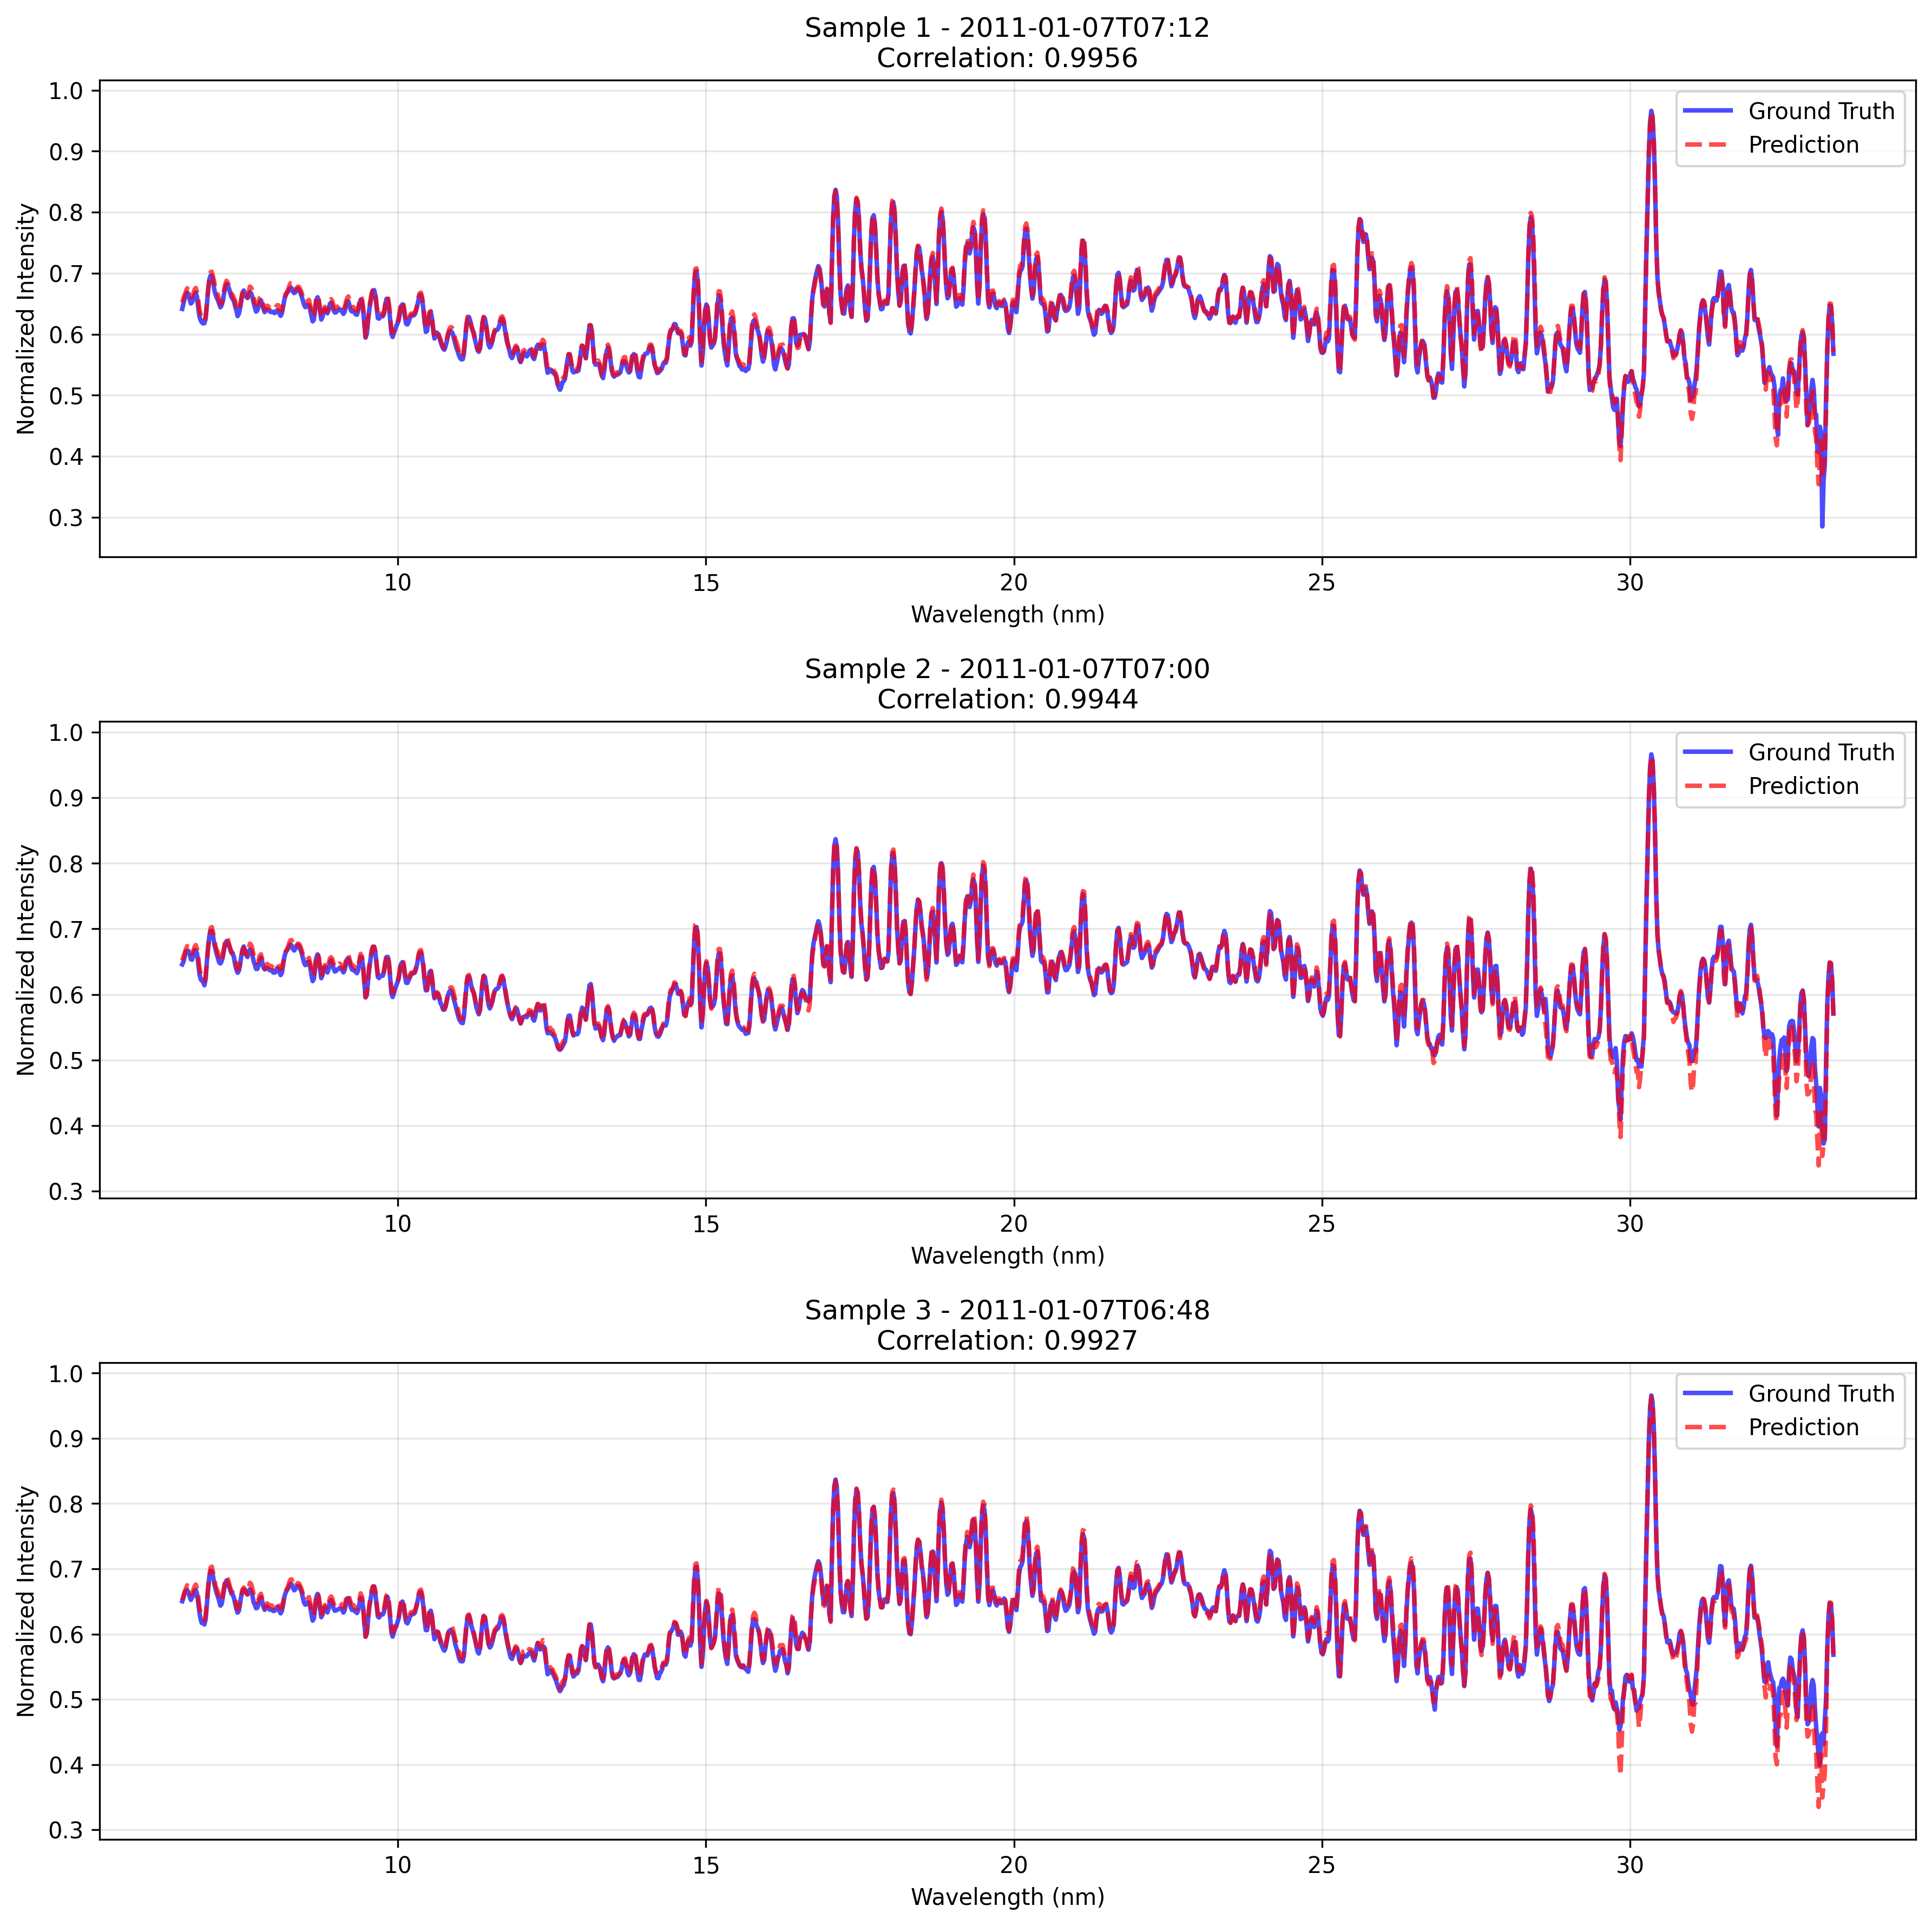

In [6]:
import IPython
saved_image_path = os.path.join(output_dir, 'euv_spectra_predictions.png')
IPython.display.Image(filename=saved_image_path)

## Understanding the Results 📊

### What you're seeing:
- **Time Input**: The timestamp of the input solar observations
- **Time Target**: The timestamp for which we're making the spectral prediction
- **Spectrum Shape**: Always 1343 (number of wavelength bins)
- **Pred Range**: Min/max values in the predicted spectrum
- **GT Range**: Min/max values in the ground truth spectrum

### Key Metrics Explained:
1. **Mean Absolute Error (MAE)**: Average absolute difference between predicted and actual spectral values (lower is better)
2. **Root Mean Square Error (RMSE)**: Square root of average squared differences (penalizes larger errors more)
3. **R² Score**: Coefficient of determination (closer to 1.0 means better predictions)
4. **Average Spectral Correlation**: How well the predicted spectrum shape matches ground truth (closer to 1.0 is better)

### Tips for interpretation:
1. **Good predictions**: High correlation (>0.9) and low MAE (<0.05)
2. **Spectral shape**: More important than absolute values - EUV lines should be in the right places
3. **Physical meaning**: Each wavelength corresponds to different coronal temperatures and plasma conditions
4. **Applications**: Space weather forecasting, solar physics research, understanding coronal heating


## Summary 🎯

Congratulations! You've successfully run EUV spectra prediction using the Surya model. 

### What you accomplished:
✅ Downloaded pre-trained model weights  
✅ Loaded and configured the spectral regression model  
✅ Ran inference on solar data  
✅ Generated 1343-dimensional spectral predictions with timestamps  
✅ Compared predictions with ground truth measurements  
✅ Calculated regression metrics (MAE, RMSE, R², Correlation)  
✅ Created spectral visualization plots  

### Understanding EUV Spectra Prediction:
- **Vector Regression Task**: Predicts 1343 continuous spectral values simultaneously
- **Wavelength Coverage**: 6.5 to 33.3 nanometers (extreme ultraviolet range)
- **Physical Significance**: Each wavelength reveals different aspects of solar coronal conditions

Happy EUV spectra forecasting! 🌞🔬📡✨
